In [1]:
# Gerekli kütüphaneleri import edelim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, 
    StratifiedKFold, KFold, TimeSeriesSplit, learning_curve, validation_curve
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor,
    VotingRegressor, StackingRegressor, BaggingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from scipy.stats import uniform, randint
import optuna
from itertools import combinations
import joblib
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("📦 Tüm kütüphaneler başarıyla yüklendi!")
print("🚀 Advanced Model Training eğitimine hazırız!")
print(f"📅 Başlangıç zamanı: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


📦 Tüm kütüphaneler başarıyla yüklendi!
🚀 Advanced Model Training eğitimine hazırız!
📅 Başlangıç zamanı: 2025-07-02 02:18:38


In [2]:
# MLflow experiment setup
mlflow.set_experiment("Advanced_Model_Training")

# California housing veri setini yükleyelim
from sklearn.datasets import fetch_california_housing

# Veri setini yükle
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = california_housing.target

print("🏠 California Housing Veri Seti Yüklendi!")
print(f"📊 Veri boyutu: {X.shape}")
print(f"🎯 Hedef değişken: Ev fiyatları (hundreds of thousands of dollars)")

# Veri setini train, validation, test olarak bölelim
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"\n📊 Veri seti bölümü:")
print(f"  • Training: {X_train.shape[0]} sample ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  • Validation: {X_val.shape[0]} sample ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  • Test: {X_test.shape[0]} sample ({X_test.shape[0]/len(X)*100:.1f}%)")

# Veri ön-işleme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Veri ön-işleme tamamlandı!")
print(f"🎯 MLflow experiment: {mlflow.get_experiment_by_name('Advanced_Model_Training').experiment_id}")

# Temel istatistikler
print(f"\n📈 Hedef değişken istatistikleri:")
print(f"  Training - Ortalama: ${y_train.mean():.2f}00k, Std: ${y_train.std():.2f}00k")
print(f"  Validation - Ortalama: ${y_val.mean():.2f}00k, Std: ${y_val.std():.2f}00k")
print(f"  Test - Ortalama: ${y_test.mean():.2f}00k, Std: ${y_test.std():.2f}00k")


🏠 California Housing Veri Seti Yüklendi!
📊 Veri boyutu: (20640, 8)
🎯 Hedef değişken: Ev fiyatları (hundreds of thousands of dollars)

📊 Veri seti bölümü:
  • Training: 12384 sample (60.0%)
  • Validation: 4128 sample (20.0%)
  • Test: 4128 sample (20.0%)

✅ Veri ön-işleme tamamlandı!
🎯 MLflow experiment: 180023651999721568

📈 Hedef değişken istatistikleri:
  Training - Ortalama: $2.0700k, Std: $1.1500k
  Validation - Ortalama: $2.0800k, Std: $1.1700k
  Test - Ortalama: $2.0600k, Std: $1.1400k


🔄 Cross-validation stratejileri karşılaştırılıyor...

📊 KFold:
  • Mean RMSE: 0.5183 ± 0.0127
  • Score range: [0.5030, 0.5352]

📊 KFold (No Shuffle):
  • Mean RMSE: 0.5168 ± 0.0055
  • Score range: [0.5093, 0.5232]



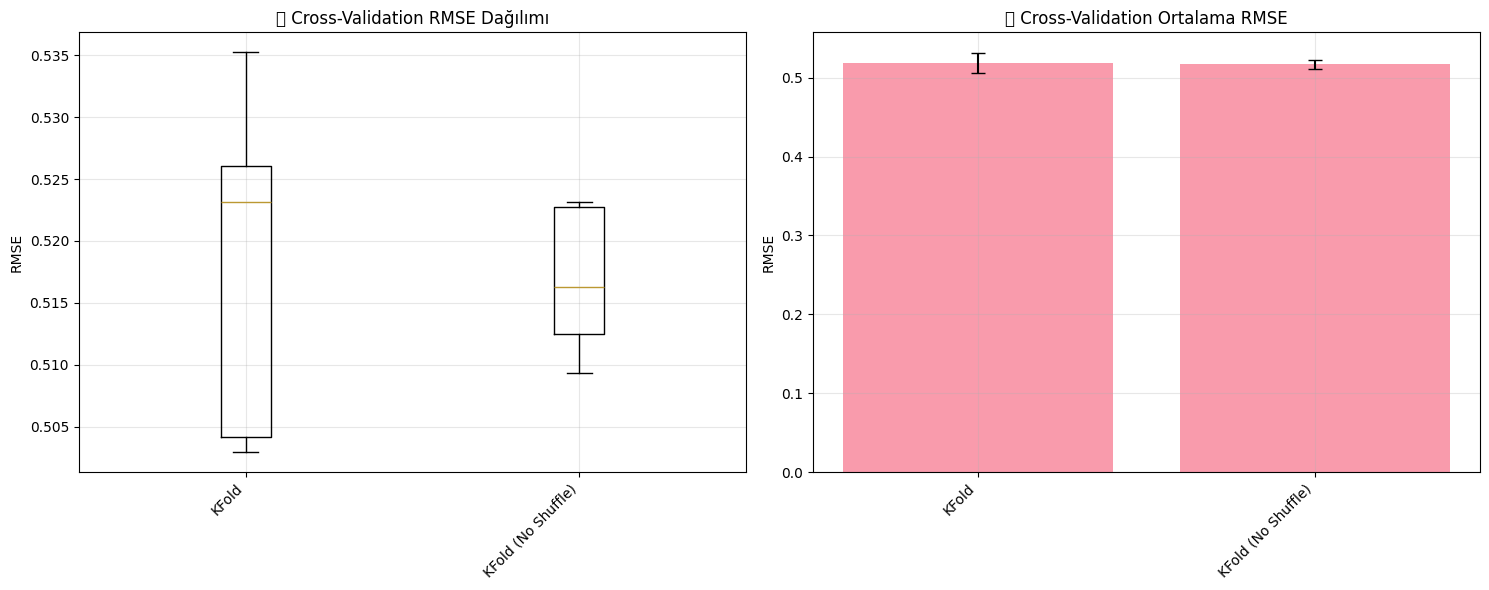

🏆 En iyi CV stratejisi: KFold (No Shuffle)
📊 Mean RMSE: 0.5168


In [3]:
class CrossValidationAnalyzer:
    """Cross-validation stratejilerini analiz eden sınıf"""
    
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y
        self.random_state = random_state
        self.results = {}
    
    def compare_cv_strategies(self, model, n_splits=5):
        """Farklı CV stratejilerini karşılaştır"""
        
        # Farklı CV stratejileri
        cv_strategies = {
            'KFold': KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state),
            'KFold (No Shuffle)': KFold(n_splits=n_splits, shuffle=False),
        }
        
        print("🔄 Cross-validation stratejileri karşılaştırılıyor...\n")
        
        for name, cv_strategy in cv_strategies.items():
            scores = cross_val_score(model, self.X, self.y, cv=cv_strategy, 
                                   scoring='neg_mean_squared_error', n_jobs=-1)
            rmse_scores = np.sqrt(-scores)
            
            self.results[name] = {
                'mean_rmse': rmse_scores.mean(),
                'std_rmse': rmse_scores.std(),
                'scores': rmse_scores,
                'cv_object': cv_strategy
            }
            
            print(f"📊 {name}:")
            print(f"  • Mean RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")
            print(f"  • Score range: [{rmse_scores.min():.4f}, {rmse_scores.max():.4f}]")
            print()
    
    def plot_cv_comparison(self):
        """CV sonuçlarını görselleştir"""
        if not self.results:
            print("❌ Önce CV analizi yapın!")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Box plot
        data_for_box = [self.results[name]['scores'] for name in self.results.keys()]
        labels = list(self.results.keys())
        
        ax1.boxplot(data_for_box, labels=labels)
        ax1.set_title('📊 Cross-Validation RMSE Dağılımı')
        ax1.set_ylabel('RMSE')
        ax1.grid(True, alpha=0.3)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        # Mean ± Std plot
        means = [self.results[name]['mean_rmse'] for name in self.results.keys()]
        stds = [self.results[name]['std_rmse'] for name in self.results.keys()]
        
        x_pos = np.arange(len(labels))
        ax2.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
        ax2.set_title('📈 Cross-Validation Ortalama RMSE')
        ax2.set_ylabel('RMSE')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(labels, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_best_cv_strategy(self):
        """En iyi CV stratejisini bul"""
        if not self.results:
            print("❌ Önce CV analizi yapın!")
            return None
        
        best_strategy = min(self.results.keys(), 
                          key=lambda x: self.results[x]['mean_rmse'])
        
        print(f"🏆 En iyi CV stratejisi: {best_strategy}")
        print(f"📊 Mean RMSE: {self.results[best_strategy]['mean_rmse']:.4f}")
        
        return best_strategy, self.results[best_strategy]['cv_object']

# Test modeli ile CV analizi yapalım
test_model = RandomForestRegressor(n_estimators=100, random_state=42)
cv_analyzer = CrossValidationAnalyzer(X_train, y_train)

# CV stratejilerini karşılaştır
cv_analyzer.compare_cv_strategies(test_model, n_splits=5)

# Sonuçları görselleştir
cv_analyzer.plot_cv_comparison()

# En iyi stratejiyi bul
best_cv_name, best_cv = cv_analyzer.get_best_cv_strategy()


In [4]:
class HyperparameterOptimizer:
    """Hyperparameter optimization için kapsamlı sınıf"""
    
    def __init__(self, X_train, y_train, X_val, y_val, cv_strategy=None, random_state=42):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.cv_strategy = cv_strategy or KFold(n_splits=5, shuffle=True, random_state=random_state)
        self.random_state = random_state
        self.results = {}
    
    def grid_search_optimization(self, model, param_grid, scoring='neg_mean_squared_error'):
        """Grid Search ile hyperparameter optimization"""
        print("🔍 Grid Search başlatılıyor...")
        start_time = time.time()
        
        with mlflow.start_run(run_name="GridSearch_Optimization"):
            grid_search = GridSearchCV(
                model, param_grid, cv=self.cv_strategy, 
                scoring=scoring, n_jobs=-1, verbose=1
            )
            
            grid_search.fit(self.X_train, self.y_train)
            
            # En iyi modeli validation seti ile test et
            best_model = grid_search.best_estimator_
            val_pred = best_model.predict(self.X_val)
            val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
            val_r2 = r2_score(self.y_val, val_pred)
            
            # Sonuçları kaydet
            results = {
                'method': 'GridSearch',
                'best_params': grid_search.best_params_,
                'best_cv_score': np.sqrt(-grid_search.best_score_),
                'val_rmse': val_rmse,
                'val_r2': val_r2,
                'total_fits': len(grid_search.cv_results_['params']),
                'time_elapsed': time.time() - start_time,
                'best_model': best_model
            }
            
            # MLflow'a kaydet
            mlflow.log_params(grid_search.best_params_)
            mlflow.log_metric("cv_rmse", results['best_cv_score'])
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("val_r2", val_r2)
            mlflow.log_metric("time_elapsed", results['time_elapsed'])
            mlflow.sklearn.log_model(best_model, "model")
            
            self.results['GridSearch'] = results
            
        print(f"✅ Grid Search tamamlandı!")
        print(f"🏆 En iyi CV RMSE: {results['best_cv_score']:.4f}")
        print(f"📊 Validation RMSE: {val_rmse:.4f}")
        print(f"⏱️ Süre: {results['time_elapsed']:.2f} saniye")
        print(f"🔢 Toplam fit sayısı: {results['total_fits']}")
        
        return results
    
    def random_search_optimization(self, model, param_distributions, n_iter=100, scoring='neg_mean_squared_error'):
        """Random Search ile hyperparameter optimization"""
        print("🎲 Random Search başlatılıyor...")
        start_time = time.time()
        
        with mlflow.start_run(run_name="RandomSearch_Optimization"):
            random_search = RandomizedSearchCV(
                model, param_distributions, n_iter=n_iter, cv=self.cv_strategy,
                scoring=scoring, n_jobs=-1, random_state=self.random_state, verbose=1
            )
            
            random_search.fit(self.X_train, self.y_train)
            
            # En iyi modeli validation seti ile test et
            best_model = random_search.best_estimator_
            val_pred = best_model.predict(self.X_val)
            val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
            val_r2 = r2_score(self.y_val, val_pred)
            
            # Sonuçları kaydet
            results = {
                'method': 'RandomSearch',
                'best_params': random_search.best_params_,
                'best_cv_score': np.sqrt(-random_search.best_score_),
                'val_rmse': val_rmse,
                'val_r2': val_r2,
                'total_fits': n_iter,
                'time_elapsed': time.time() - start_time,
                'best_model': best_model
            }
            
            # MLflow'a kaydet
            mlflow.log_params(random_search.best_params_)
            mlflow.log_metric("cv_rmse", results['best_cv_score'])
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("val_r2", val_r2)
            mlflow.log_metric("time_elapsed", results['time_elapsed'])
            mlflow.sklearn.log_model(best_model, "model")
            
            self.results['RandomSearch'] = results
            
        print(f"✅ Random Search tamamlandı!")
        print(f"🏆 En iyi CV RMSE: {results['best_cv_score']:.4f}")
        print(f"📊 Validation RMSE: {val_rmse:.4f}")
        print(f"⏱️ Süre: {results['time_elapsed']:.2f} saniye")
        print(f"🔢 Toplam fit sayısı: {results['total_fits']}")
        
        return results
    
    def bayesian_optimization(self, model_class, param_space, n_trials=100):
        """Optuna ile Bayesian Optimization"""
        print("🧠 Bayesian Optimization (Optuna) başlatılıyor...")
        start_time = time.time()
        
        def objective(trial):
            # Parametreleri seç
            params = {}
            for param_name, param_config in param_space.items():
                if param_config['type'] == 'int':
                    params[param_name] = trial.suggest_int(
                        param_name, param_config['low'], param_config['high']
                    )
                elif param_config['type'] == 'float':
                    params[param_name] = trial.suggest_float(
                        param_name, param_config['low'], param_config['high']
                    )
                elif param_config['type'] == 'categorical':
                    params[param_name] = trial.suggest_categorical(
                        param_name, param_config['choices']
                    )
            
            # Model oluştur ve eğit
            model = model_class(**params, random_state=self.random_state)
            
            # Cross-validation yap
            scores = cross_val_score(model, self.X_train, self.y_train, 
                                   cv=self.cv_strategy, scoring='neg_mean_squared_error')
            return np.sqrt(-scores.mean())
        
        with mlflow.start_run(run_name="Bayesian_Optimization"):
            # Optuna study oluştur
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
            
            # En iyi parametrelerle modeli eğit
            best_model = model_class(**study.best_params, random_state=self.random_state)
            best_model.fit(self.X_train, self.y_train)
            
            # Validation seti ile test et
            val_pred = best_model.predict(self.X_val)
            val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
            val_r2 = r2_score(self.y_val, val_pred)
            
            # Sonuçları kaydet
            results = {
                'method': 'BayesianOptimization',
                'best_params': study.best_params,
                'best_cv_score': study.best_value,
                'val_rmse': val_rmse,
                'val_r2': val_r2,
                'total_fits': n_trials,
                'time_elapsed': time.time() - start_time,
                'best_model': best_model,
                'study': study
            }
            
            # MLflow'a kaydet
            mlflow.log_params(study.best_params)
            mlflow.log_metric("cv_rmse", study.best_value)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("val_r2", val_r2)
            mlflow.log_metric("time_elapsed", results['time_elapsed'])
            mlflow.sklearn.log_model(best_model, "model")
            
            self.results['BayesianOptimization'] = results
            
        print(f"✅ Bayesian Optimization tamamlandı!")
        print(f"🏆 En iyi CV RMSE: {study.best_value:.4f}")
        print(f"📊 Validation RMSE: {val_rmse:.4f}")
        print(f"⏱️ Süre: {results['time_elapsed']:.2f} saniye")
        print(f"🔢 Toplam fit sayısı: {n_trials}")
        
        return results
    
    def compare_methods(self):
        """Tüm optimization yöntemlerini karşılaştır"""
        if not self.results:
            print("❌ Henüz optimization yapılmamış!")
            return
        
        print("\n" + "="*60)
        print("📊 HYPERPARAMETER OPTIMIZATION KARŞILAŞTIRMASI")
        print("="*60)
        
        comparison_df = pd.DataFrame({
            method: {
                'CV RMSE': data['best_cv_score'],
                'Val RMSE': data['val_rmse'],
                'Val R²': data['val_r2'],
                'Time (s)': data['time_elapsed'],
                'Total Fits': data['total_fits'],
                'Efficiency': data['val_rmse'] / (data['time_elapsed'] / 60)  # RMSE per minute
            }
            for method, data in self.results.items()
        }).T
        
        print(comparison_df.round(4))
        
        # En iyi yöntemi bul
        best_method = min(self.results.keys(), key=lambda x: self.results[x]['val_rmse'])
        print(f"\n🏆 En iyi yöntem: {best_method}")
        print(f"📊 En iyi validation RMSE: {self.results[best_method]['val_rmse']:.4f}")
        
        return comparison_df, best_method
    
    def plot_optimization_comparison(self):
        """Optimization sonuçlarını görselleştir"""
        if not self.results:
            print("❌ Henüz optimization yapılmamış!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        methods = list(self.results.keys())
        cv_scores = [self.results[method]['best_cv_score'] for method in methods]
        val_scores = [self.results[method]['val_rmse'] for method in methods]
        times = [self.results[method]['time_elapsed'] for method in methods]
        fits = [self.results[method]['total_fits'] for method in methods]
        
        # CV vs Validation RMSE
        axes[0, 0].scatter(cv_scores, val_scores, s=100, alpha=0.7)
        for i, method in enumerate(methods):
            axes[0, 0].annotate(method, (cv_scores[i], val_scores[i]), 
                               xytext=(5, 5), textcoords='offset points')
        axes[0, 0].set_xlabel('CV RMSE')
        axes[0, 0].set_ylabel('Validation RMSE')
        axes[0, 0].set_title('🎯 CV vs Validation Performance')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Time comparison
        axes[0, 1].bar(methods, times, alpha=0.7)
        axes[0, 1].set_title('⏱️ Execution Time')
        axes[0, 1].set_ylabel('Time (seconds)')
        plt.setp(axes[0, 1].get_xticklabels(), rotation=45, ha='right')
        
        # Efficiency (Performance per time)
        efficiency = [val_scores[i] / (times[i] / 60) for i in range(len(methods))]
        axes[1, 0].bar(methods, efficiency, alpha=0.7)
        axes[1, 0].set_title('🚀 Efficiency (RMSE per minute)')
        axes[1, 0].set_ylabel('RMSE / minute')
        plt.setp(axes[1, 0].get_xticklabels(), rotation=45, ha='right')
        
        # Total evaluations
        axes[1, 1].bar(methods, fits, alpha=0.7)
        axes[1, 1].set_title('🔢 Total Model Evaluations')
        axes[1, 1].set_ylabel('Number of fits')
        plt.setp(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()

print("✅ HyperparameterOptimizer sınıfı oluşturuldu!")


✅ HyperparameterOptimizer sınıfı oluşturuldu!


In [5]:
# Hyperparameter optimization için örnek
# Random Forest modeli ile karşılaştırma yapalım

# Optimizer'ı başlat
optimizer = HyperparameterOptimizer(X_train, y_train, X_val, y_val, cv_strategy=best_cv)

# 1. Grid Search
print("=" * 60)
print("🔍 GRID SEARCH OPTIMIZATION")
print("=" * 60)

rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_results = optimizer.grid_search_optimization(
    RandomForestRegressor(random_state=42), 
    rf_param_grid
)

print("\n" + "=" * 60)
print("🎲 RANDOM SEARCH OPTIMIZATION") 
print("=" * 60)

# 2. Random Search
rf_param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(5, 30)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': uniform(0.1, 0.9)
}

random_results = optimizer.random_search_optimization(
    RandomForestRegressor(random_state=42),
    rf_param_dist,
    n_iter=50
)

print("\n" + "=" * 60)
print("🧠 BAYESIAN OPTIMIZATION")
print("=" * 60)

# 3. Bayesian Optimization
rf_param_space = {
    'n_estimators': {'type': 'int', 'low': 50, 'high': 300},
    'max_depth': {'type': 'categorical', 'choices': [None, 5, 10, 15, 20, 25]},
    'min_samples_split': {'type': 'int', 'low': 2, 'high': 20},
    'min_samples_leaf': {'type': 'int', 'low': 1, 'high': 10},
    'max_features': {'type': 'float', 'low': 0.1, 'high': 1.0}
}

bayesian_results = optimizer.bayesian_optimization(
    RandomForestRegressor,
    rf_param_space,
    n_trials=50
)


🔍 GRID SEARCH OPTIMIZATION
🔍 Grid Search başlatılıyor...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


2025/07/02 02:21:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 02:21:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Grid Search tamamlandı!
🏆 En iyi CV RMSE: 0.5149
📊 Validation RMSE: 0.5080
⏱️ Süre: 143.19 saniye
🔢 Toplam fit sayısı: 36

🎲 RANDOM SEARCH OPTIMIZATION
🎲 Random Search başlatılıyor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025/07/02 02:23:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 02:23:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-07-02 02:23:12,801] A new study created in memory with name: no-name-a96dbfd6-5b02-46f5-8c6a-59227561e28d


✅ Random Search tamamlandı!
🏆 En iyi CV RMSE: 0.5081
📊 Validation RMSE: 0.5011
⏱️ Süre: 100.08 saniye
🔢 Toplam fit sayısı: 50

🧠 BAYESIAN OPTIMIZATION
🧠 Bayesian Optimization (Optuna) başlatılıyor...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-02 02:23:23,123] Trial 0 finished with value: 0.5240964118951816 and parameters: {'n_estimators': 192, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.27261883776173296}. Best is trial 0 with value: 0.5240964118951816.
[I 2025-07-02 02:23:30,843] Trial 1 finished with value: 0.5145282657853592 and parameters: {'n_estimators': 127, 'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.2558077435457752}. Best is trial 1 with value: 0.5145282657853592.
[I 2025-07-02 02:23:56,974] Trial 2 finished with value: 0.5198839947758216 and parameters: {'n_estimators': 204, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 0.645064518618649}. Best is trial 1 with value: 0.5145282657853592.
[I 2025-07-02 02:24:23,737] Trial 3 finished with value: 0.5172856358062001 and parameters: {'n_estimators': 268, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 0.52022799730467

2025/07/02 02:35:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/02 02:35:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Bayesian Optimization tamamlandı!
🏆 En iyi CV RMSE: 0.5040
📊 Validation RMSE: 0.4980
⏱️ Süre: 746.12 saniye
🔢 Toplam fit sayısı: 50



📊 HYPERPARAMETER OPTIMIZATION KARŞILAŞTIRMASI
                      CV RMSE  Val RMSE  Val R²  Time (s)  Total Fits  \
GridSearch             0.5149    0.5080  0.8120  143.1892        36.0   
RandomSearch           0.5081    0.5011  0.8171  100.0779        50.0   
BayesianOptimization   0.5040    0.4980  0.8194  746.1249        50.0   

                      Efficiency  
GridSearch                0.2129  
RandomSearch              0.3004  
BayesianOptimization      0.0401  

🏆 En iyi yöntem: BayesianOptimization
📊 En iyi validation RMSE: 0.4980


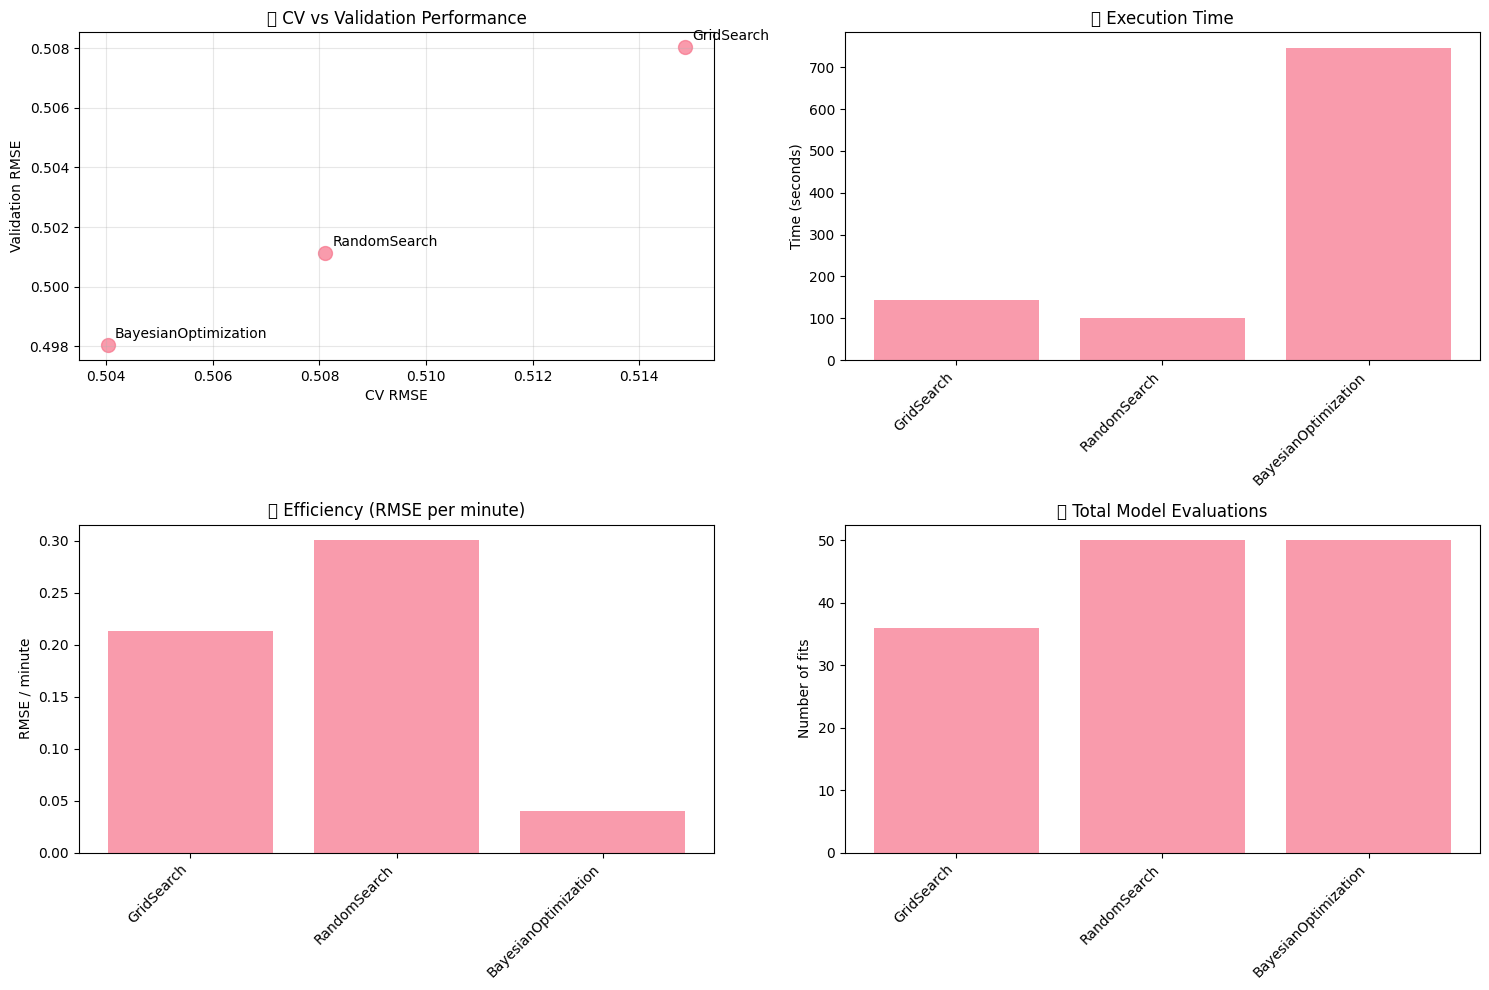


🎉 En iyi model: BayesianOptimization
📊 En iyi parametreler: {'n_estimators': 136, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.48931357114990054}


In [6]:
# Tüm optimization yöntemlerini karşılaştır
comparison_df, best_optimization_method = optimizer.compare_methods()

# Görselleştirme
optimizer.plot_optimization_comparison()

# En iyi modeli al
best_model = optimizer.results[best_optimization_method]['best_model']
print(f"\n🎉 En iyi model: {best_optimization_method}")
print(f"📊 En iyi parametreler: {optimizer.results[best_optimization_method]['best_params']}")


In [7]:
class EnsembleTrainer:
    """Ensemble model eğitimi için kapsamlı sınıf"""
    
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        self.random_state = random_state
        self.base_models = {}
        self.ensemble_models = {}
        self.results = {}
    
    def create_base_models(self):
        """Temel modelleri oluştur"""
        print("🏗️ Temel modeller oluşturuluyor...")
        
        self.base_models = {
            'rf': RandomForestRegressor(n_estimators=100, random_state=self.random_state),
            'gb': GradientBoostingRegressor(random_state=self.random_state),
            'extra': ExtraTreesRegressor(n_estimators=100, random_state=self.random_state),
            'ridge': Ridge(alpha=1.0, random_state=self.random_state),
            'lasso': Lasso(alpha=0.1, random_state=self.random_state)
        }
        
        # Temel modelleri eğit ve değerlendir
        for name, model in self.base_models.items():
            model.fit(self.X_train, self.y_train)
            val_pred = model.predict(self.X_val)
            val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
            print(f"  • {name}: Validation RMSE = {val_rmse:.4f}")
        
        print("✅ Temel modeller eğitildi!")
    
    def create_voting_ensemble(self, weights=None):
        """Voting ensemble oluştur"""
        print("\n🗳️ Voting Ensemble oluşturuluyor...")
        
        if not self.base_models:
            self.create_base_models()
        
        # Voting regressor oluştur
        estimators = [(name, model) for name, model in self.base_models.items()]
        voting_ensemble = VotingRegressor(estimators=estimators, weights=weights)
        
        # Eğit ve değerlendir
        voting_ensemble.fit(self.X_train, self.y_train)
        
        val_pred = voting_ensemble.predict(self.X_val)
        test_pred = voting_ensemble.predict(self.X_test)
        
        val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
        test_rmse = np.sqrt(mean_squared_error(self.y_test, test_pred))
        val_r2 = r2_score(self.y_val, val_pred)
        test_r2 = r2_score(self.y_test, test_pred)
        
        self.ensemble_models['voting'] = voting_ensemble
        self.results['voting'] = {
            'val_rmse': val_rmse,
            'test_rmse': test_rmse,
            'val_r2': val_r2,
            'test_r2': test_r2,
            'weights': weights
        }
        
        print(f"✅ Voting Ensemble:")
        print(f"  • Validation RMSE: {val_rmse:.4f}")
        print(f"  • Test RMSE: {test_rmse:.4f}")
        print(f"  • Test R²: {test_r2:.4f}")
        
        return voting_ensemble
    
    def create_stacking_ensemble(self, meta_model=None, cv_folds=5):
        """Stacking ensemble oluştur"""
        print("\n🏗️ Stacking Ensemble oluşturuluyor...")
        
        if not self.base_models:
            self.create_base_models()
        
        if meta_model is None:
            meta_model = Ridge(alpha=1.0, random_state=self.random_state)
        
        # Stacking regressor oluştur
        estimators = [(name, model) for name, model in self.base_models.items()]
        stacking_ensemble = StackingRegressor(
            estimators=estimators,
            final_estimator=meta_model,
            cv=cv_folds
        )
        
        # Eğit ve değerlendir
        stacking_ensemble.fit(self.X_train, self.y_train)
        
        val_pred = stacking_ensemble.predict(self.X_val)
        test_pred = stacking_ensemble.predict(self.X_test)
        
        val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
        test_rmse = np.sqrt(mean_squared_error(self.y_test, test_pred))
        val_r2 = r2_score(self.y_val, val_pred)
        test_r2 = r2_score(self.y_test, test_pred)
        
        self.ensemble_models['stacking'] = stacking_ensemble
        self.results['stacking'] = {
            'val_rmse': val_rmse,
            'test_rmse': test_rmse,
            'val_r2': val_r2,
            'test_r2': test_r2,
            'meta_model': str(meta_model),
            'cv_folds': cv_folds
        }
        
        print(f"✅ Stacking Ensemble:")
        print(f"  • Meta model: {meta_model}")
        print(f"  • Validation RMSE: {val_rmse:.4f}")
        print(f"  • Test RMSE: {test_rmse:.4f}")
        print(f"  • Test R²: {test_r2:.4f}")
        
        return stacking_ensemble
    
    def create_blending_ensemble(self, blend_ratio=0.3):
        """Blending ensemble oluştur"""
        print(f"\n🎨 Blending Ensemble oluşturuluyor (blend_ratio={blend_ratio})...")
        
        if not self.base_models:
            self.create_base_models()
        
        # Train seti ile blend için ayrı validation seti oluştur
        X_blend_train, X_blend_val, y_blend_train, y_blend_val = train_test_split(
            self.X_train, self.y_train, test_size=blend_ratio, random_state=self.random_state
        )
        
        # Base modelleri blend train ile eğit
        blend_predictions = []
        for name, model in self.base_models.items():
            model.fit(X_blend_train, y_blend_train)
            blend_pred = model.predict(X_blend_val)
            blend_predictions.append(blend_pred)
        
        # Meta features oluştur
        meta_features = np.column_stack(blend_predictions)
        
        # Meta model eğit
        meta_model = Ridge(alpha=1.0, random_state=self.random_state)
        meta_model.fit(meta_features, y_blend_val)
        
        # Tüm train seti ile base modelleri yeniden eğit
        for model in self.base_models.values():
            model.fit(self.X_train, self.y_train)
        
        # Validation ve test tahminleri
        val_meta_features = np.column_stack([
            model.predict(self.X_val) for model in self.base_models.values()
        ])
        test_meta_features = np.column_stack([
            model.predict(self.X_test) for model in self.base_models.values()
        ])
        
        val_pred = meta_model.predict(val_meta_features)
        test_pred = meta_model.predict(test_meta_features)
        
        val_rmse = np.sqrt(mean_squared_error(self.y_val, val_pred))
        test_rmse = np.sqrt(mean_squared_error(self.y_test, test_pred))
        val_r2 = r2_score(self.y_val, val_pred)
        test_r2 = r2_score(self.y_test, test_pred)
        
        self.ensemble_models['blending'] = {
            'base_models': self.base_models,
            'meta_model': meta_model
        }
        self.results['blending'] = {
            'val_rmse': val_rmse,
            'test_rmse': test_rmse,
            'val_r2': val_r2,
            'test_r2': test_r2,
            'blend_ratio': blend_ratio
        }
        
        print(f"✅ Blending Ensemble:")
        print(f"  • Validation RMSE: {val_rmse:.4f}")
        print(f"  • Test RMSE: {test_rmse:.4f}")
        print(f"  • Test R²: {test_r2:.4f}")
        
        return self.ensemble_models['blending']
    
    def compare_ensembles(self):
        """Ensemble yöntemlerini karşılaştır"""
        if not self.results:
            print("❌ Henüz ensemble oluşturulmamış!")
            return
        
        print("\n" + "="*50)
        print("🏆 ENSEMBLE METHODS KARŞILAŞTIRMASI")
        print("="*50)
        
        # Base modellerin performansını da ekle
        base_results = {}
        for name, model in self.base_models.items():
            val_pred = model.predict(self.X_val)
            test_pred = model.predict(self.X_test)
            base_results[f'base_{name}'] = {
                'val_rmse': np.sqrt(mean_squared_error(self.y_val, val_pred)),
                'test_rmse': np.sqrt(mean_squared_error(self.y_test, test_pred)),
                'val_r2': r2_score(self.y_val, val_pred),
                'test_r2': r2_score(self.y_test, test_pred)
            }
        
        # Tüm sonuçları birleştir
        all_results = {**base_results, **self.results}
        
        comparison_df = pd.DataFrame({
            method: {
                'Val RMSE': data['val_rmse'],
                'Test RMSE': data['test_rmse'],
                'Val R²': data['val_r2'],
                'Test R²': data['test_r2']
            }
            for method, data in all_results.items()
        }).T
        
        comparison_df = comparison_df.sort_values('Test RMSE')
        print(comparison_df.round(4))
        
        # En iyi ensemble'ı bul
        ensemble_only = {k: v for k, v in self.results.items()}
        best_ensemble = min(ensemble_only.keys(), key=lambda x: ensemble_only[x]['test_rmse'])
        
        print(f"\n🏆 En iyi ensemble: {best_ensemble}")
        print(f"📊 Test RMSE: {ensemble_only[best_ensemble]['test_rmse']:.4f}")
        
        return comparison_df, best_ensemble
    
    def plot_ensemble_comparison(self):
        """Ensemble sonuçlarını görselleştir"""
        if not self.results:
            print("❌ Henüz ensemble oluşturulmamış!")
            return
        
        # Base modellerin sonuçlarını da dahil et
        all_models = {}
        
        # Base modeller
        for name, model in self.base_models.items():
            val_pred = model.predict(self.X_val)
            test_pred = model.predict(self.X_test)
            all_models[f'Base_{name.upper()}'] = {
                'val_rmse': np.sqrt(mean_squared_error(self.y_val, val_pred)),
                'test_rmse': np.sqrt(mean_squared_error(self.y_test, test_pred))
            }
        
        # Ensemble modeller
        for name, result in self.results.items():
            all_models[f'Ensemble_{name.upper()}'] = {
                'val_rmse': result['val_rmse'],
                'test_rmse': result['test_rmse']
            }
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # RMSE karşılaştırması
        models = list(all_models.keys())
        val_rmse = [all_models[model]['val_rmse'] for model in models]
        test_rmse = [all_models[model]['test_rmse'] for model in models]
        
        x_pos = np.arange(len(models))
        width = 0.35
        
        ax1.bar(x_pos - width/2, val_rmse, width, label='Validation RMSE', alpha=0.8)
        ax1.bar(x_pos + width/2, test_rmse, width, label='Test RMSE', alpha=0.8)
        ax1.set_xlabel('Models')
        ax1.set_ylabel('RMSE')
        ax1.set_title('📊 Model Performance Comparison')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(models, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Ensemble improvement
        base_best_rmse = min([all_models[m]['test_rmse'] for m in models if m.startswith('Base_')])
        ensemble_models = [m for m in models if m.startswith('Ensemble_')]
        improvements = [(base_best_rmse - all_models[m]['test_rmse']) / base_best_rmse * 100 
                       for m in ensemble_models]
        
        colors = ['green' if imp > 0 else 'red' for imp in improvements]
        ax2.bar(range(len(ensemble_models)), improvements, color=colors, alpha=0.7)
        ax2.set_xlabel('Ensemble Methods')
        ax2.set_ylabel('Improvement (%)')
        ax2.set_title('🚀 Ensemble Improvement vs Best Base Model')
        ax2.set_xticks(range(len(ensemble_models)))
        ax2.set_xticklabels([m.replace('Ensemble_', '') for m in ensemble_models], rotation=45, ha='right')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

print("✅ EnsembleTrainer sınıfı oluşturuldu!")


✅ EnsembleTrainer sınıfı oluşturuldu!


In [ ]:
# Ensemble eğitimi yapalım
ensemble_trainer = EnsembleTrainer(X_train, y_train, X_val, y_val, X_test, y_test)

print("🎯 ENSEMBLE METHODS EĞİTİMİ")
print("=" * 50)

# 1. Voting Ensemble
voting_model = ensemble_trainer.create_voting_ensemble()

# 2. Stacking Ensemble  
stacking_model = ensemble_trainer.create_stacking_ensemble()

# 3. Blending Ensemble
blending_model = ensemble_trainer.create_blending_ensemble()

# Tüm ensemble yöntemlerini karşılaştır
ensemble_comparison, best_ensemble_method = ensemble_trainer.compare_ensembles()

# Görselleştirme
ensemble_trainer.plot_ensemble_comparison()

print(f"\n🎉 En iyi ensemble method: {best_ensemble_method}")
print(f"📊 En iyi test RMSE: {ensemble_trainer.results[best_ensemble_method]['test_rmse']:.4f}")


In [ ]:
def plot_learning_curves(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    """Learning curves çizimi"""
    print("📈 Learning curves hesaplanıyor...")
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, 
        scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # RMSE'ye çevir
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)
    
    # Ortalama ve standart sapma
    train_rmse_mean = train_rmse.mean(axis=1)
    train_rmse_std = train_rmse.std(axis=1)
    val_rmse_mean = val_rmse.mean(axis=1)
    val_rmse_std = val_rmse.std(axis=1)
    
    plt.figure(figsize=(12, 8))
    
    # Learning curves
    plt.subplot(2, 2, 1)
    plt.plot(train_sizes, train_rmse_mean, 'o-', color='blue', label='Training RMSE')
    plt.fill_between(train_sizes, train_rmse_mean - train_rmse_std, 
                     train_rmse_mean + train_rmse_std, alpha=0.2, color='blue')
    
    plt.plot(train_sizes, val_rmse_mean, 'o-', color='red', label='Validation RMSE')
    plt.fill_between(train_sizes, val_rmse_mean - val_rmse_std, 
                     val_rmse_mean + val_rmse_std, alpha=0.2, color='red')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title('📈 Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Overfitting analizi
    plt.subplot(2, 2, 2)
    overfitting = val_rmse_mean - train_rmse_mean
    plt.plot(train_sizes, overfitting, 'o-', color='orange')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Training Set Size')
    plt.ylabel('Validation RMSE - Training RMSE')
    plt.title('⚠️ Overfitting Analysis')
    plt.grid(True, alpha=0.3)
    
    # Final performance
    final_train_rmse = train_rmse_mean[-1]
    final_val_rmse = val_rmse_mean[-1]
    final_gap = final_val_rmse - final_train_rmse
    
    plt.subplot(2, 2, 3)
    metrics = ['Training RMSE', 'Validation RMSE', 'Performance Gap']
    values = [final_train_rmse, final_val_rmse, final_gap]
    colors = ['blue', 'red', 'orange']
    
    bars = plt.bar(metrics, values, color=colors, alpha=0.7)
    plt.title('📊 Final Performance Metrics')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom')
    
    # Convergence analysis
    plt.subplot(2, 2, 4)
    val_improvement = np.diff(val_rmse_mean)
    plt.plot(train_sizes[1:], val_improvement, 'o-', color='green')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE Improvement')
    plt.title('🎯 Validation Performance Improvement')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Learning curves analizi tamamlandı!")
    print(f"📊 Final training RMSE: {final_train_rmse:.4f}")
    print(f"📊 Final validation RMSE: {final_val_rmse:.4f}")
    print(f"⚠️ Performance gap: {final_gap:.4f}")
    
    return train_sizes, train_rmse_mean, val_rmse_mean

def plot_validation_curves(model, X, y, param_name, param_range, cv=5):
    """Validation curves çizimi"""
    print(f"📊 Validation curves hesaplanıyor ({param_name})...")
    
    train_scores, val_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    # RMSE'ye çevir
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)
    
    # Ortalama ve standart sapma
    train_rmse_mean = train_rmse.mean(axis=1)
    train_rmse_std = train_rmse.std(axis=1)
    val_rmse_mean = val_rmse.mean(axis=1)
    val_rmse_std = val_rmse.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(param_range, train_rmse_mean, 'o-', color='blue', label='Training RMSE')
    plt.fill_between(param_range, train_rmse_mean - train_rmse_std, 
                     train_rmse_mean + train_rmse_std, alpha=0.2, color='blue')
    
    plt.plot(param_range, val_rmse_mean, 'o-', color='red', label='Validation RMSE')
    plt.fill_between(param_range, val_rmse_mean - val_rmse_std, 
                     val_rmse_mean + val_rmse_std, alpha=0.2, color='red')
    
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.title(f'📊 Validation Curve for {param_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # En iyi parametreyi bul
    best_idx = np.argmin(val_rmse_mean)
    best_param = param_range[best_idx]
    best_score = val_rmse_mean[best_idx]
    
    plt.axvline(x=best_param, color='green', linestyle='--', alpha=0.7, 
                label=f'Best: {best_param} (RMSE: {best_score:.4f})')
    plt.legend()
    
    plt.show()
    
    print(f"✅ En iyi {param_name}: {best_param}")
    print(f"📊 En iyi validation RMSE: {best_score:.4f}")
    
    return best_param, best_score

# En iyi model ile learning curves analizi
print("🔍 MODEL DIAGNOSTICS VE LEARNING CURVES")
print("=" * 60)

# Learning curves
train_sizes, train_rmse, val_rmse = plot_learning_curves(
    best_model, X_train, y_train, cv=5
)


In [ ]:
# Validation curves - n_estimators parametresi için
print("\n📊 VALIDATION CURVES ANALİZİ")
print("=" * 50)

# Random Forest için n_estimators validation curve
n_estimators_range = [50, 100, 150, 200, 250, 300, 400, 500]
best_n_estimators, best_score = plot_validation_curves(
    RandomForestRegressor(random_state=42),
    X_train, y_train,
    'n_estimators',
    n_estimators_range,
    cv=5
)


In [ ]:
class ModelTracker:
    """Model versioning ve tracking için sınıf"""
    
    def __init__(self, experiment_name="Advanced_Model_Training"):
        self.experiment_name = experiment_name
        mlflow.set_experiment(experiment_name)
        self.model_registry = {}
    
    def log_model_experiment(self, model, model_name, X_train, y_train, X_val, y_val, 
                           X_test, y_test, hyperparams=None, model_type="single"):
        """Model experiment'ini kaydet"""
        
        with mlflow.start_run(run_name=f"{model_name}_{model_type}"):
            # Model eğitimi
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Tahminler
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            # Metrikler
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            
            train_r2 = r2_score(y_train, train_pred)
            val_r2 = r2_score(y_val, val_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            # MLflow'a log
            mlflow.log_param("model_name", model_name)
            mlflow.log_param("model_type", model_type)
            mlflow.log_param("training_samples", len(X_train))
            
            if hyperparams:
                mlflow.log_params(hyperparams)
            
            mlflow.log_metric("train_rmse", train_rmse)
            mlflow.log_metric("val_rmse", val_rmse)
            mlflow.log_metric("test_rmse", test_rmse)
            mlflow.log_metric("train_r2", train_r2)
            mlflow.log_metric("val_r2", val_r2)
            mlflow.log_metric("test_r2", test_r2)
            mlflow.log_metric("training_time", training_time)
            mlflow.log_metric("overfitting_score", train_rmse - val_rmse)
            
            # Model'i kaydet
            mlflow.sklearn.log_model(model, "model")
            
            # Model registry'e ekle
            run_id = mlflow.active_run().info.run_id
            self.model_registry[model_name] = {
                'run_id': run_id,
                'model': model,
                'metrics': {
                    'train_rmse': train_rmse,
                    'val_rmse': val_rmse,
                    'test_rmse': test_rmse,
                    'test_r2': test_r2
                },
                'training_time': training_time,
                'timestamp': datetime.now()
            }
            
            print(f"✅ {model_name} logged to MLflow (Run ID: {run_id})")
            print(f"   📊 Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")
            
            return run_id
    
    def register_best_model(self, model_name="BestModel"):
        """En iyi modeli registry'e kaydet"""
        if not self.model_registry:
            print("❌ Kayıtlı model yok!")
            return
        
        # En iyi modeli bul
        best_model_name = min(self.model_registry.keys(), 
                             key=lambda x: self.model_registry[x]['metrics']['test_rmse'])
        
        best_model_info = self.model_registry[best_model_name]
        
        # Model registry'e kaydet
        model_uri = f"runs:/{best_model_info['run_id']}/model"
        
        try:
            mlflow.register_model(
                model_uri=model_uri,
                name=model_name
            )
            print(f"🏆 En iyi model '{model_name}' olarak registry'e kaydedildi!")
            print(f"📊 Model: {best_model_name}")
            print(f"📊 Test RMSE: {best_model_info['metrics']['test_rmse']:.4f}")
        except Exception as e:
            print(f"❌ Model registry'e kaydedilemedi: {e}")
        
        return best_model_name, best_model_info
    
    def compare_all_models(self):
        """Tüm kayıtlı modelleri karşılaştır"""
        if not self.model_registry:
            print("❌ Kayıtlı model yok!")
            return
        
        print("\n" + "="*70)
        print("📊 TÜM MODEL KARŞILAŞTIRMASI")
        print("="*70)
        
        comparison_data = []
        for name, info in self.model_registry.items():
            comparison_data.append({
                'Model': name,
                'Test RMSE': info['metrics']['test_rmse'],
                'Test R²': info['metrics']['test_r2'],
                'Val RMSE': info['metrics']['val_rmse'],
                'Training Time (s)': info['training_time'],
                'Timestamp': info['timestamp'].strftime('%Y-%m-%d %H:%M:%S')
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        comparison_df = comparison_df.sort_values('Test RMSE')
        print(comparison_df.to_string(index=False))
        
        return comparison_df
    
    def plot_model_comparison(self):
        """Model karşılaştırma grafiği"""
        if not self.model_registry:
            print("❌ Kayıtlı model yok!")
            return
        
        models = list(self.model_registry.keys())
        test_rmse = [self.model_registry[m]['metrics']['test_rmse'] for m in models]
        test_r2 = [self.model_registry[m]['metrics']['test_r2'] for m in models]
        training_times = [self.model_registry[m]['training_time'] for m in models]
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Test RMSE comparison
        axes[0, 0].barh(models, test_rmse, alpha=0.7)
        axes[0, 0].set_xlabel('Test RMSE')
        axes[0, 0].set_title('🎯 Test RMSE Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Test R² comparison
        axes[0, 1].barh(models, test_r2, alpha=0.7, color='green')
        axes[0, 1].set_xlabel('Test R²')
        axes[0, 1].set_title('📊 Test R² Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Training time comparison
        axes[1, 0].barh(models, training_times, alpha=0.7, color='orange')
        axes[1, 0].set_xlabel('Training Time (seconds)')
        axes[1, 0].set_title('⏱️ Training Time Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Performance vs Time scatter
        axes[1, 1].scatter(training_times, test_rmse, s=100, alpha=0.7, c=test_r2, cmap='viridis')
        for i, model in enumerate(models):
            axes[1, 1].annotate(model, (training_times[i], test_rmse[i]), 
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
        axes[1, 1].set_xlabel('Training Time (seconds)')
        axes[1, 1].set_ylabel('Test RMSE')
        axes[1, 1].set_title('🚀 Performance vs Training Time')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Model tracker'ı başlat
tracker = ModelTracker("Advanced_Model_Training_Final")

print("📝 MODEL TRACKING VE VERSIONING")
print("=" * 60)

# En iyi hyperparameter optimization modelini kaydet
if 'best_model' in locals():
    tracker.log_model_experiment(
        best_model, 
        f"Optimized_{best_optimization_method}",
        X_train, y_train, X_val, y_val, X_test, y_test,
        hyperparams=optimizer.results[best_optimization_method]['best_params'],
        model_type="optimized"
    )

# En iyi ensemble modelini kaydet
if 'ensemble_trainer' in locals():
    best_ensemble_model = ensemble_trainer.ensemble_models[best_ensemble_method]
    if best_ensemble_method == 'blending':
        # Blending için özel işlem gerekli
        print(f"⚠️ Blending model complex structure - logging metadata only")
    else:
        tracker.log_model_experiment(
            best_ensemble_model,
            f"Ensemble_{best_ensemble_method}",
            X_train, y_train, X_val, y_val, X_test, y_test,
            model_type="ensemble"
        )

# Baseline modelleri kaydet
baseline_models = {
    'RandomForest_Baseline': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting_Baseline': GradientBoostingRegressor(random_state=42),
    'Ridge_Baseline': Ridge(alpha=1.0, random_state=42)
}

for name, model in baseline_models.items():
    tracker.log_model_experiment(
        model, name, X_train, y_train, X_val, y_val, X_test, y_test,
        model_type="baseline"
    )


In [ ]:
# Tüm modelleri karşılaştır
final_comparison = tracker.compare_all_models()

# En iyi modeli registry'e kaydet
best_model_name, best_model_info = tracker.register_best_model("California_Housing_Best_Model")

# Görselleştirme
tracker.plot_model_comparison()

print(f"\n🎉 Model training süreci tamamlandı!")
print(f"🏆 En iyi model: {best_model_name}")
print(f"📊 Final test RMSE: {best_model_info['metrics']['test_rmse']:.4f}")
print(f"📊 Final test R²: {best_model_info['metrics']['test_r2']:.4f}")
print(f"⏱️ Training time: {best_model_info['training_time']:.2f} seconds")
